In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def parse_tcp_file(filename):
    """Parses the TCP packet log file to extract time and packet sizes."""
    data = pd.read_csv(filename, names=["Time", "SrcPort", "DstPort", "Length"], skiprows=1)
    data["Time"] = pd.to_numeric(data["Time"], errors='coerce')
    data["Length"] = pd.to_numeric(data["Length"], errors='coerce')
    return data

def parse_tx_power_file(filename):
    """Parses the TX power log file to extract time and power values."""
    times = []
    powers = []

    with open(filename, 'r') as file:
        for line in file:
            match = re.search(r'Time: ([\d\.]+)s.*New Power: ([-\d]+) dBm', line)
            if match:
                times.append(float(match.group(1)))
                powers.append(int(match.group(2)))

    return pd.DataFrame({"Time": times, "Power": powers})

def smooth_tx_power(tx_power_data, window_size=0.2):
    """Applies a moving average to smooth the transmit power data."""
    time_range = np.arange(tx_power_data["Time"].min(), tx_power_data["Time"].max(), window_size)
    smoothed_output = []

    for t in time_range:
        filtered = tx_power_data[(tx_power_data["Time"] >= t - window_size / 2) &
                                 (tx_power_data["Time"] < t + window_size / 2)]
        avg_power = filtered["Power"].mean() if not filtered.empty else np.nan
        smoothed_output.append([t, avg_power])

    return pd.DataFrame(smoothed_output, columns=["Time", "Power"])

def compute_throughput(tcp_data, window_size=0.15):
    """Compute TCP throughput using a sliding window."""
    time_range = np.arange(tcp_data["Time"].min(), tcp_data["Time"].max(), window_size)
    thr_output = []
    for t in time_range:
        filtered = tcp_data[(tcp_data["Time"] >= t - window_size / 2) & (tcp_data["Time"] < t + window_size / 2)]
        throughput = (filtered["Length"].sum() * 8) / (window_size * 1e6) if not filtered.empty else 0  # Convert to Mbps
        thr_output.append([t, throughput])
    return pd.DataFrame(thr_output, columns=["Time", "Throughput"])

def compute_loss_rate_time_series(ap_data, ms_data, window_size=0.15):
    """Computes packet loss rate over time using a sliding window."""
    time_range = np.arange(ap_data["Time"].min(), ap_data["Time"].max(), window_size)
    loss_rate_output = []

    for t in time_range:
        ap_filtered = ap_data[(ap_data["Time"] >= t - window_size / 2) & (ap_data["Time"] < t + window_size / 2)]
        ms_filtered = ms_data[(ms_data["Time"] >= t - window_size / 2) & (ms_data["Time"] < t + window_size / 2)]

        total_sent = ap_filtered["Length"].sum()
        total_received = ms_filtered["Length"].sum()

        loss_rate = (total_sent - total_received) / total_sent if total_sent > 0 else 0
        loss_rate_output.append([t, loss_rate])

    return pd.DataFrame(loss_rate_output, columns=["Time", "LossRate"])

def plot_metrics(vel, step_sizes):
    """Plots throughput, transmit power, and loss rate for given velocity, showing stepSize variations in one figure."""

    avg_throughputs = []
    avg_tx_powers = []
    avg_loss_rates = []

    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tcp_file = f"tcp_pack_vel{vel}_step{step}.csv"
        ms_data = parse_tcp_file(tcp_file)
        throughput_data = compute_throughput(ms_data)

        avg_throughput = throughput_data["Throughput"].mean()
        avg_throughputs.append(avg_throughput)

        plt.plot(throughput_data["Time"], throughput_data["Throughput"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Throughput (Mbps)")
    plt.title(f"Throughput for velocity {vel}")
    plt.ylim(15, 19)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tx_power_file = f"tx_power_vel{vel}_step{step}.txt"
        tx_power_data = parse_tx_power_file(tx_power_file)
        smoothed_tx_power = smooth_tx_power(tx_power_data)

        avg_tx_power = smoothed_tx_power["Power"].mean()
        avg_tx_powers.append(avg_tx_power)

        plt.plot(smoothed_tx_power["Time"], smoothed_tx_power["Power"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Power (dBm)")
    plt.title(f"Smoothed Transmit Power for velocity {vel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        ms_file = f"tcp_pack_vel{vel}_step{step}.csv"
        ap_file = f"tcp_pack_ap_vel{vel}_step{step}.csv"

        ms_data = parse_tcp_file(ms_file)
        ap_data = parse_tcp_file(ap_file)

        loss_rate_data = compute_loss_rate_time_series(ap_data, ms_data)
        avg_loss_rate = loss_rate_data["LossRate"].mean()
        avg_loss_rates.append(avg_loss_rate)

        plt.plot(loss_rate_data["Time"], loss_rate_data["LossRate"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Loss Rate")
    plt.title(f"Loss Rate Over Time for velocity {vel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n===== Summary of Metrics =====")
    for step, thr, tx, loss in zip(step_sizes, avg_throughputs, avg_tx_powers, avg_loss_rates):
        print(f"Velocity {vel} - Step {step}:")
        print(f"  - Avg Throughput: {thr:.2f} Mbps")
        print(f"  - Avg Transmit Power: {tx:.2f} dBm")
        print(f"  - Loss Rate: {loss:.2%}")


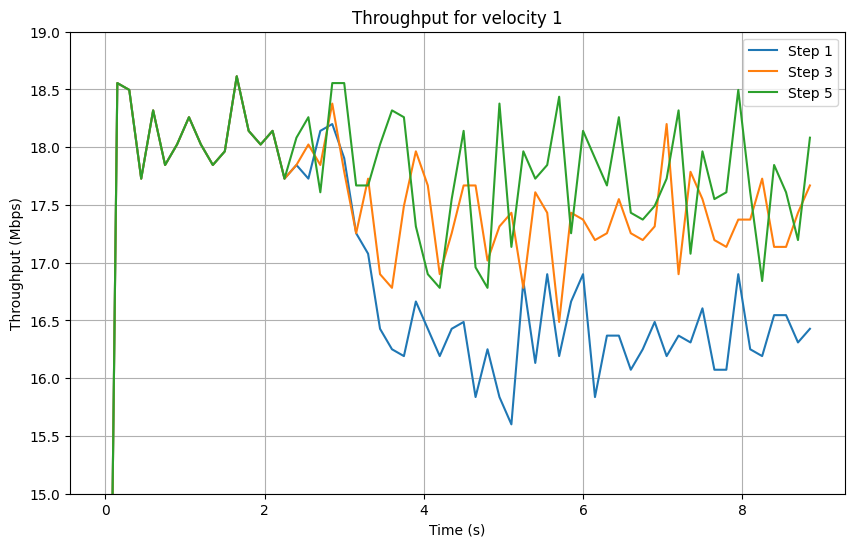

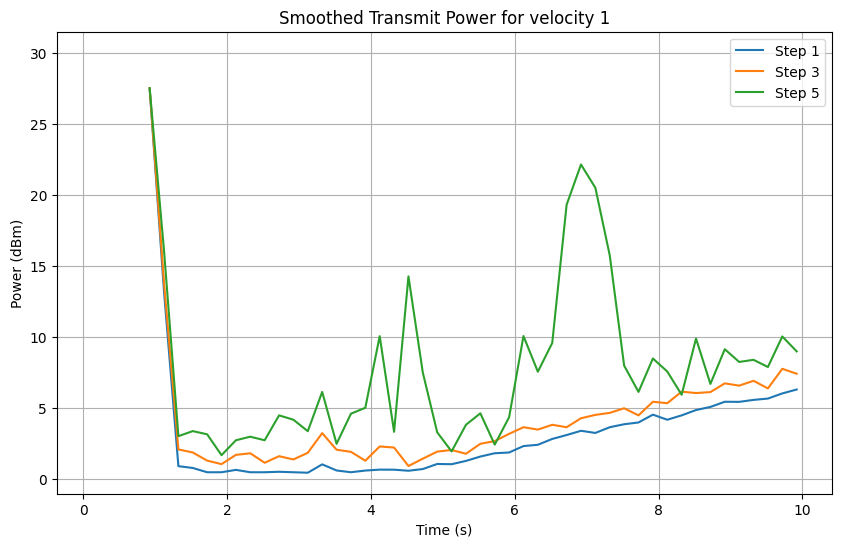

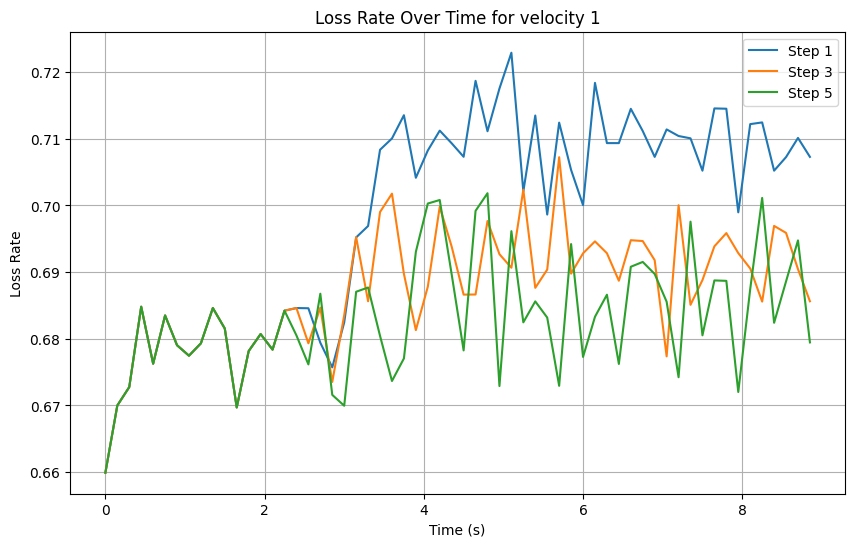


===== Summary of Metrics =====
Velocity 1 - Step 1:
  - Avg Throughput: 16.83 Mbps
  - Avg Transmit Power: 3.78 dBm
  - Loss Rate: 69.84%
Velocity 1 - Step 3:
  - Avg Throughput: 17.46 Mbps
  - Avg Transmit Power: 4.80 dBm
  - Loss Rate: 68.73%
Velocity 1 - Step 5:
  - Avg Throughput: 17.69 Mbps
  - Avg Transmit Power: 8.30 dBm
  - Loss Rate: 68.33%


In [22]:
plot_metrics(1, [1, 3, 5])

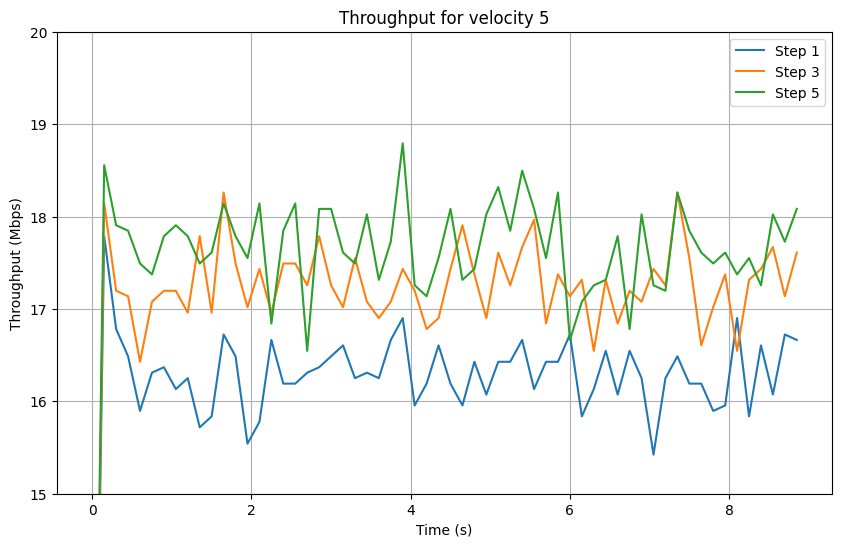

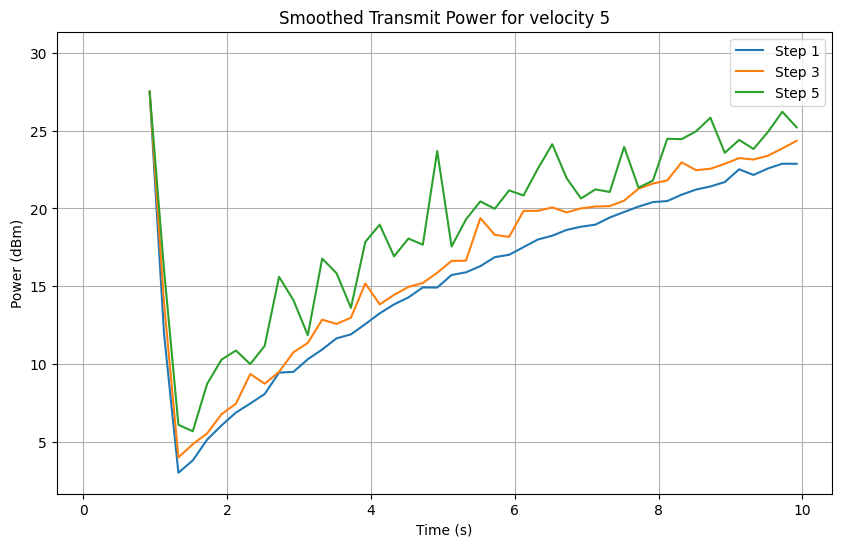

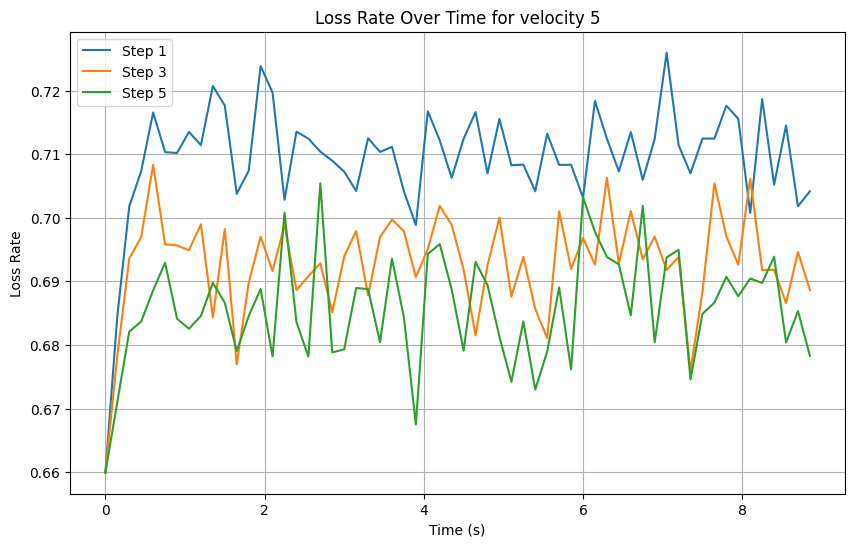


===== Summary of Metrics =====
Velocity 5 - Step 1:
  - Avg Throughput: 16.20 Mbps
  - Avg Transmit Power: 15.91 dBm
  - Loss Rate: 70.94%
Velocity 5 - Step 3:
  - Avg Throughput: 17.15 Mbps
  - Avg Transmit Power: 17.03 dBm
  - Loss Rate: 69.28%
Velocity 5 - Step 5:
  - Avg Throughput: 17.55 Mbps
  - Avg Transmit Power: 19.21 dBm
  - Loss Rate: 68.58%


In [19]:
plot_metrics(5, [1, 3, 5])

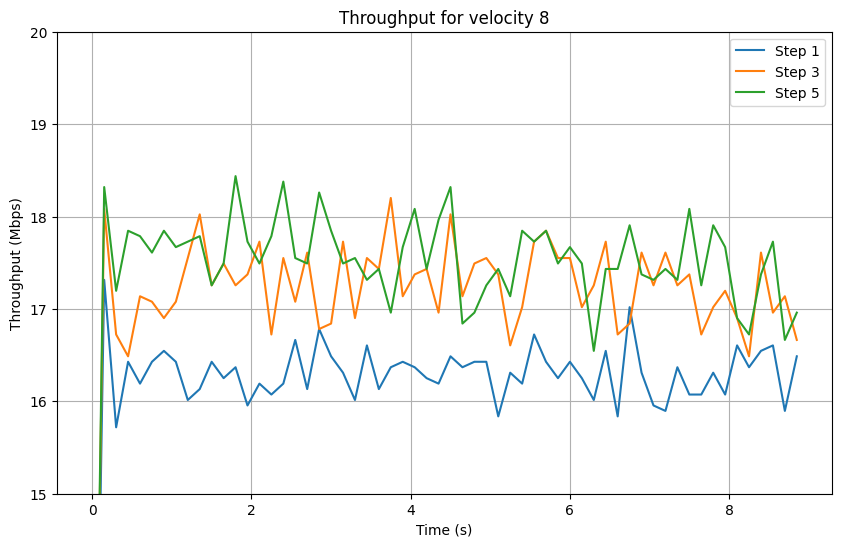

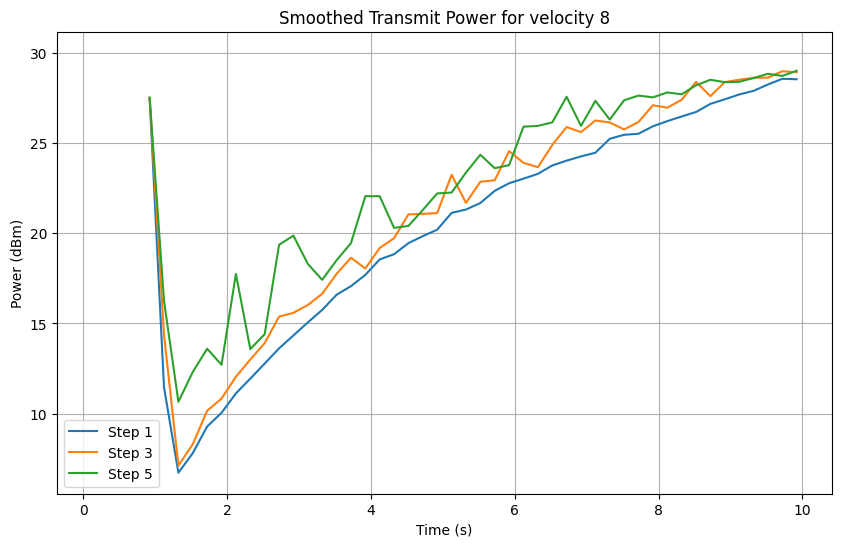

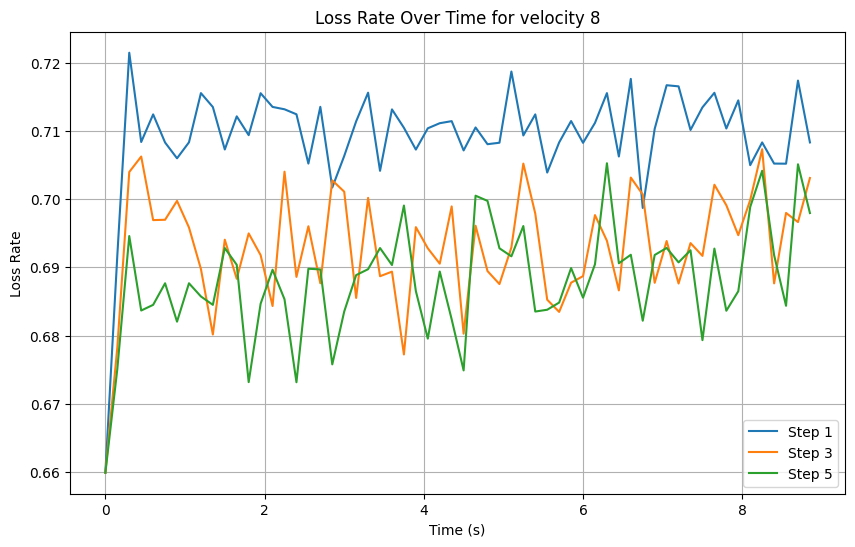


===== Summary of Metrics =====
Velocity 8 - Step 1:
  - Avg Throughput: 16.20 Mbps
  - Avg Transmit Power: 20.74 dBm
  - Loss Rate: 70.94%
Velocity 8 - Step 3:
  - Avg Throughput: 17.14 Mbps
  - Avg Transmit Power: 21.71 dBm
  - Loss Rate: 69.30%
Velocity 8 - Step 5:
  - Avg Throughput: 17.42 Mbps
  - Avg Transmit Power: 22.96 dBm
  - Loss Rate: 68.81%


In [20]:
plot_metrics(8, [1, 3, 5])